In [1]:
# https://towardsdatascience.com/modeling-customer-lifetime-value-with-lifetimes-71171a35f654

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas_gbq
import os
pd.options.display.max_columns = 100
pd.options.display.max_rows = 300

import pandas as pd
from google.oauth2 import service_account

from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy

from tqdm.auto import tqdm

#plt.style.use('ggplot')

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import seaborn as sns
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
#df = pd.read_csv('data.csv')

- load date

In [ ]:
from lifetimes.datasets import load_dataset

transactions = load_dataset(
    filename='CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)

In [30]:
transactions.head(3)

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96


- restructure table to RFM format

In [31]:
from lifetimes.utils import summary_data_from_transaction_data

rfm = summary_data_from_transaction_data(transactions=transactions,
                                         customer_id_col='customer_id',
                                         datetime_col='date',
                                         monetary_value_col = 'amount',
                                         observation_period_end=pd.to_datetime('2022-07-28'),
                                         freq='W')

In [32]:
rfm

,frequency,recency,T,monetary_value
customer_id,,,,
4,3.0,49.0,1334.0,23.723333
18,0.0,0.0,1334.0,0.000000
21,1.0,2.0,1334.0,11.770000
50,0.0,0.0,1334.0,0.000000
60,0.0,0.0,1330.0,0.000000
...,...,...,...,...
23537,2.0,53.0,1322.0,19.775000
23551,5.0,24.0,1322.0,44.928000
23554,1.0,44.0,1322.0,24.600000


- Holdout split

In [34]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions=transactions,
                                               customer_id_col='customer_id', 
                                               datetime_col='date',
                                               monetary_value_col = 'amount',
                                               freq='W',
                                               calibration_period_end='1998-01-01',
                                               observation_period_end='1998-06-30' )

rfm_cal_holdout.head(3)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.0,26.0
18,0.0,0.0,52.0,0.000000,0.0,0.0,26.0
21,1.0,2.0,52.0,11.770000,0.0,0.0,26.0


- Fitting

In [35]:
from lifetimes import BetaGeoFitter

# instantiation of BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fitting of BG-NBD model
bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], 
        recency=rfm_cal_holdout['recency_cal'], 
        T=rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.53, alpha: 6.73, b: 1.97, r: 0.28>

In [37]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.281847,0.014034,0.254340,0.309354
alpha,6.732810,0.532304,5.689494,7.776126
a,0.532360,0.122632,0.292000,0.772719
b,1.971260,0.575322,0.843628,3.098892


- Camparing artificial and real data

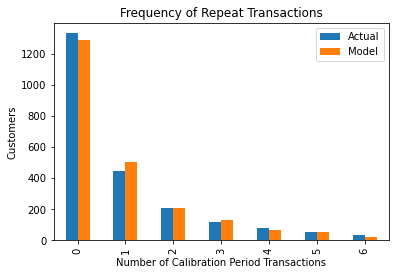

In [39]:
from lifetimes.plotting import plot_period_transactions

_ = plot_period_transactions(bgf) 

- Making predictions

In [41]:
# First, we choose a sample customer. 
sample_customer = rfm_cal_holdout.iloc[20] 

In [42]:
# Let's inspect his frequency, recency and T both for the calibration and observation periods:
sample_customer

frequency_cal              3.000000
recency_cal               28.000000
T_cal                     52.000000
monetary_value_cal        25.076667
frequency_holdout          2.000000
monetary_value_holdout    29.480000
duration_holdout          26.000000
Name: 226, dtype: float64

In [44]:
# This function calculates the conditional expected number of transactions in the given time length
n_transactions_pred = bgf.predict(t=26, # we set it to 26 weeks (the length of the observation period)
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])

n_transactions_pred

0.7647440846242359

In [45]:
alive_prob = bgf.conditional_probability_alive(frequency=sample_customer['frequency_cal'], 
                                               recency=sample_customer['recency_cal'], 
                                               T=sample_customer['T_cal'])

alive_prob

array([0.57089896])

- Comparison of real and predicted number of transactions

In [46]:
# the real number of transactions in the observation period, which equals frequency_holdout + 1
rfm_cal_holdout["n_transactions_holdout_real"]  = rfm_cal_holdout["frequency_holdout"] + 1

In [47]:
# the predicted number of transactions in the next 26 weeks (length of the observation period)
rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=26, 
                                                    frequency=rfm_cal_holdout['frequency_cal'], 
                                                    recency=rfm_cal_holdout['recency_cal'], 
                                                    T=rfm_cal_holdout['T_cal'])

In [48]:
# comparison of the real and predicted transactions
rfm_cal_holdout[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].head()

,n_transactions_holdout_real,n_transactions_holdout_pred
customer_id,,
4,1.0,1.155554
18,1.0,0.118167
21,1.0,0.128974
50,1.0,0.118167
60,1.0,0.126350


In [50]:

from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_true = rfm_cal_holdout["n_transactions_holdout_real"],
                          y_pred = rfm_cal_holdout["n_transactions_holdout_pred"],
                          squared = False)

RMSE

1.3536793286521

- Visualization

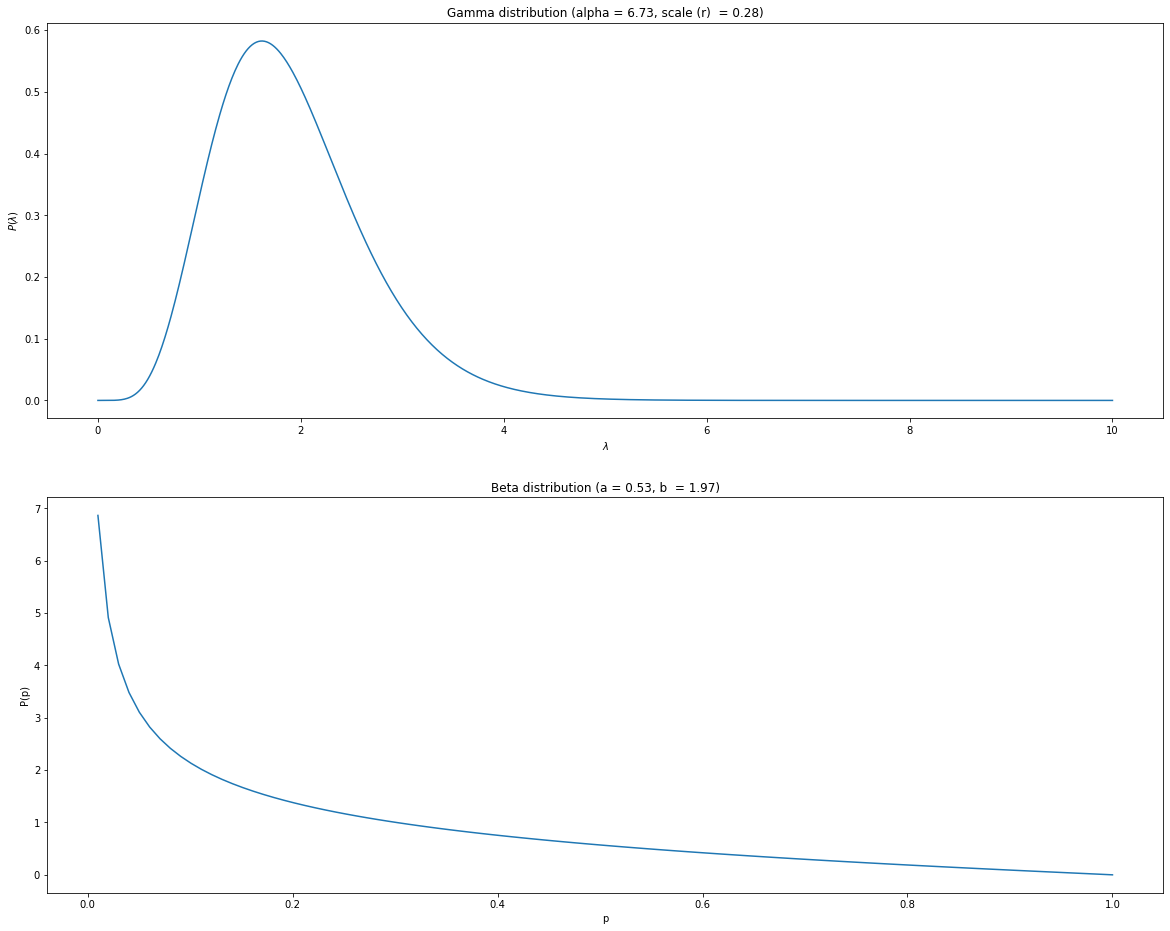

In [51]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows =2, figsize = (20, 16))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=bgf.params_["alpha"], scale=bgf.params_["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {bgf.params_["alpha"]:.2f}, scale (r)  = {bgf.params_["r"]:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')


x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf.params_["a"], b=bgf.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {bgf.params_["a"]:.2f}, b  = {bgf.params_["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()